In [10]:
from datetime import datetime
from pydantic import BaseModel

class Candle(BaseModel):
    ts: datetime
    meta: str
    open: float
    high: float
    low: float
    close: float
    volume: float

In [11]:
import pymongo
import os
from dotenv import load_dotenv

load_dotenv()

client = pymongo.MongoClient(os.environ.get("MONGO_URL"))
database = client.get_database(os.environ.get("DATABASE"))
candles_collection = database.get_collection("MinuteCandles")

In [48]:
def project_profit(instrument_key: str, entry_time: datetime, stop_loss_percent: float, trailing_percent: float):
    """
    Projects profit/loss based on entry time and trailing stop loss

    The bot will execute sell order whenever the stoploss hits. If stoplos doesn't hit, it will sell at 3PM.

    Here stop loss is update every minute because we have minute interval of data.
    In real world it is suposed to be updated every consecutive api call.

    Args:
        - `instrument_key` (str) : ID of the premium 
        - `entry_time` (datetime) : Time when entered
        - `stop_loss_percent` (float) : % of trailing stop loss set for the premium
        - `trailing_percent` (float) : % of increase before stop loss is updated
    """
    entry_price: float = -1
    stop_loss: float = -1
    exit_price: float = -1
    trailing_target: float = -1

    historical_data = list(candles_collection.find({
        "meta": instrument_key
    }))

        
    value_list = []
    for data in historical_data:
        candle: Candle = Candle(**data)
        
        # Entry 
        if(candle.ts > entry_time and entry_price == -1):
            entry_price = candle.open
            stop_loss = entry_price - entry_price*stop_loss_percent
            trailing_target = entry_price + entry_price*trailing_percent
            print(stop_loss)
        
        if entry_price != -1:
            value = {
                "stop_loss": stop_loss,
                "trailing_target": trailing_target,
                "premium": candle.low,
                "time": candle.ts
            }
            value_list.append(value)
            
            # Exit
            if (candle.low < stop_loss or (candle.ts == 15 and candle.ts == 10)):
                exit_price = candle.close
                break

            # Trailing Stoploss
            if (candle.high > trailing_target):
                stop_loss = stop_loss + stop_loss*trailing_percent
                trailing_target = trailing_target + trailing_target*trailing_percent
            

            
    
    profit = exit_price - entry_price

    result = {
        "EntryTime": entry_time,
        "ExitTime": candle.ts,
        "EntryPrice": entry_price,
        "ExitPrice": exit_price,
        "Profit": exit_price - entry_price,
        "Profit %":  (profit/entry_price)*100,
    }
    print(result)
    return value_list

In [53]:
stop_loss_percent_list = [15, 16, 17, 18, 19, 20]
trailing_percent_list = [5]

result_value_list = []
for stop_loss in stop_loss_percent_list:
    for trailing_percent in trailing_percent_list:
        if trailing_percent <= stop_loss:
            value_list = project_profit(
                instrument_key="NSE_FO|67303",
                entry_time=datetime(
                    year=2023,
                    month=10,
                    day=23,
                    hour=9,
                    minute=28,
                    second=0
                ),
                stop_loss_percent=stop_loss/100,
                trailing_percent=trailing_percent/100
            )
            result_value_list.append({
                "stop_loss": stop_loss,
                "trailing_percent": trailing_percent,
                "profit": ((value_list[-1].get("premium") - value_list[0].get("premium"))/value_list[0].get("premium"))*100,
                "value_list": value_list
            })



79.73
{'EntryTime': datetime.datetime(2023, 10, 23, 9, 28), 'ExitTime': datetime.datetime(2023, 10, 23, 11, 57), 'EntryPrice': 93.8, 'ExitPrice': 140.25, 'Profit': 46.45, 'Profit %': 49.52025586353945}
78.792
{'EntryTime': datetime.datetime(2023, 10, 23, 9, 28), 'ExitTime': datetime.datetime(2023, 10, 23, 11, 59), 'EntryPrice': 93.8, 'ExitPrice': 136.3, 'Profit': 42.500000000000014, 'Profit %': 45.309168443496816}
77.854
{'EntryTime': datetime.datetime(2023, 10, 23, 9, 28), 'ExitTime': datetime.datetime(2023, 10, 23, 15, 29), 'EntryPrice': 93.8, 'ExitPrice': -1, 'Profit': -94.8, 'Profit %': -101.06609808102345}
76.916
{'EntryTime': datetime.datetime(2023, 10, 23, 9, 28), 'ExitTime': datetime.datetime(2023, 10, 23, 15, 29), 'EntryPrice': 93.8, 'ExitPrice': -1, 'Profit': -94.8, 'Profit %': -101.06609808102345}
75.978
{'EntryTime': datetime.datetime(2023, 10, 23, 9, 28), 'ExitTime': datetime.datetime(2023, 10, 23, 15, 29), 'EntryPrice': 93.8, 'ExitPrice': -1, 'Profit': -94.8, 'Profit %': 

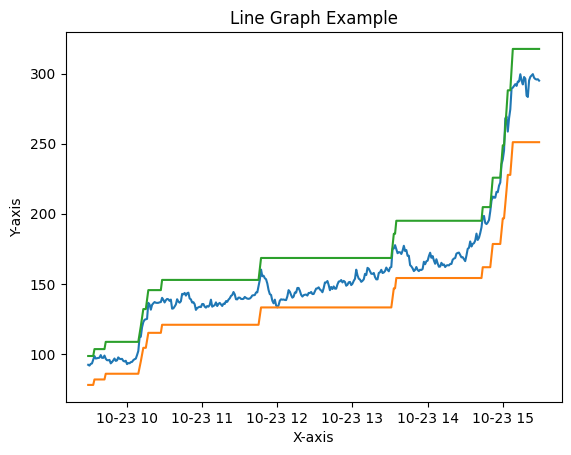

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Data for the line graph
# entry_time = datetime(
#                 year=2023,
#                 month=10,
#                 day=23,
#                 hour=9,
#                 minute=28,
#                 second=0
#             )
# time_list = []
# while entry_time < datetime(
#                 year=2023,
#                 month=10,
#                 day=23,
#                 hour=15,
#                 minute=30,
#                 second=0
#             ):
#     time_list.append(entry_time.strftime("%H:%M"))
#     entry_time = entry_time + timedelta(minutes=1)

# max_len = len(time_list)

# for index, instance_list in enumerate(result_value_list):
#     if instance_list.get("stop_loss") == 20 and instance_list.get("trailing_percent") == 5:
#         y1 = [value.get("premium") for value in instance_list.get("value_list")]
#         y1 = np.pad(y1, (0, max_len - len(y1)), 'constant', constant_values=(np.nan))
#         plt.plot(time_list, y1, label=f"Premium{index}")
#         print(index)
#         break
index = 2
time_list = [value.get("time") for value in result_value_list[index].get("value_list")]
premium_list = [value.get("premium") for value in result_value_list[index].get("value_list")]
stop_loss_list = [value.get("stop_loss") for value in result_value_list[index].get("value_list")]
trailing_target_list = [value.get("trailing_target") for value in result_value_list[index].get("value_list")]

# Create the line graph
plt.plot(time_list, premium_list, label="Premium")
plt.plot(time_list, stop_loss_list, label="StopLoss")
plt.plot(time_list, trailing_target_list, label="TrailingTarget")

# Adding labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Graph Example')

# Display the plot
plt.show()
